In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib

from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn import tree
# from sklearn.tree import export_graphviz
from six import StringIO 
import pydotplus

import warnings
warnings.filterwarnings("ignore")

import altair as alt 
alt.data_transformers.disable_max_rows()

from ast import literal_eval

import sys
sys.path.append("..")
from network_analysis.load_datasets import get_updated_shxco_data
from network_analysis.generate_network_metrics import *
from network_analysis.create_networks import *
from network_analysis.read_write_networks import *
from network_analysis.visualize_networks import * 
from network_analysis.feature_engineering_borrowers import *
members_df, books_df, borrow_events, events_df = get_updated_shxco_data(get_subscription=False)

In [123]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LDA(),
]

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:
len(members_df[members_df.borrow_count == 0]), len(members_df[members_df.borrow_count > 0])

(4632, 603)

In [109]:
members_data = members_df.copy()

In [171]:
def compare_models(X, y, title):
    
    training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
    CV = 10
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    # print(len(cv_df))
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
        #   print(model_name)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    # print(len(cv_df))
        
    sns.boxplot(x='model_name', y='accuracy', data=cv_df).set_title(title)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    plt.clf()

    

In [176]:
def sample_estimator_sizes(estimator_sizes, X, y, is_binned):
    estimator_results = []
    for n_estimators in estimator_sizes:
        training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
        x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=0,
            verbose=0,
            class_weight='balanced')
        rf_model = rf_model.fit(X=x_train, y=y_train)
        y_pred = rf_model.predict(x_val)
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        # print('number of estimators: ', n_estimators)
        # print('precision: {}'.format(precision), 'recall: {}'.format(recall), 'accuracy: {}'.format(accuracy))

        kfold = KFold(n_splits=10, shuffle=True, random_state=1)
        results = cross_val_score(rf_model, x_train, y_train,scoring='accuracy', cv=kfold)
        # print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

        results_dict = {'estimator': n_estimators, 'kfold_accuracy': results.mean(), 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'binned': is_binned}
        estimator_results.append(pd.DataFrame([results_dict]))
    estimator_results_df = pd.concat(estimator_results)
    return estimator_results_df

In [357]:
def compare_feature_results(members_final, updated_members_data, feature_categories, is_binned):
    models = []
    feature_results = []
    for cols in feature_categories:
        # print(cols)
        X = members_final[cols]
        y = updated_members_data['is_borrower']
        training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
        x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
        rf_model = RandomForestClassifier(
            n_estimators=50,
            random_state=0,
            verbose=0,
            class_weight='balanced')
        rf_model = rf_model.fit(X=x_train, y=y_train)
        y_pred = rf_model.predict(x_val)
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        # print('features: ', cols)
        # print('precision: {}'.format(precision), 'recall: {}'.format(recall), 'accuracy: {}'.format(accuracy))

        kfold = KFold(n_splits=10, shuffle=True, random_state=1)
        results = cross_val_score(rf_model, x_train, y_train,scoring='accuracy', cv=kfold)
        # print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

        results_dict = {'features': cols, 'kfold_accuracy': results.mean(), 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'binned': is_binned, f'importance': rf_model.feature_importances_}
        feature_results.append(pd.DataFrame([results_dict]))
        models.append({'model': rf_model, 'features': cols, 'X': X, 'y': y})
    feature_results_df = pd.concat(feature_results)
    return feature_results_df, models

Initially run model with all features, comparing binned and unbinned features

### Binned Features

In [512]:
geographic_cols = [ 'addresses', 'postal_codes',
    'arrondissements', 'coordinates','nationalities', ]
letter_cols = ['first_letter', 'last_letter']
person_cols = ['title', 'gender', 'is_organization']
famous_cols = ['has_viaf', 'has_wikipedia']
bio_cols = ['birth_year', 'death_year', ]

In [513]:
# First binned
bin_membership_years = True
bin_subscription_lengths = True
bin_members_final, bin_updated_members_data, bin_days, bin_year_cols, bin_volumes = build_feature_data(members_data, events_df, bin_membership_years, bin_subscription_lengths)

In [514]:
bin_subscription_cols = bin_volumes + ['subscription_count']
final_cols = letter_cols + person_cols+ bin_subscription_cols+ famous_cols + bio_cols + bin_days + bin_year_cols + geographic_cols
X = bin_members_final[final_cols]
y = bin_updated_members_data['is_borrower']

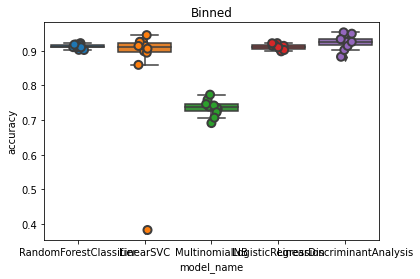

<Figure size 432x288 with 0 Axes>

In [515]:
compare_models(X, y, 'Binned')

In [516]:
estimator_sizes = [10, 50, 100, 200]
binned_estimator_results = sample_estimator_sizes(estimator_sizes, X, y, is_binned=True)

In [517]:
feature_categories = [letter_cols, person_cols, bin_subscription_cols, famous_cols, bio_cols, geographic_cols, bin_days, bin_year_cols]

In [518]:
binned_feature_results, binned_models = compare_feature_results(bin_members_final, bin_updated_members_data,feature_categories, is_binned=True)

In [519]:
from dtreeviz.trees import dtreeviz # remember to load the package

In [520]:
# First binned
bin_membership_years = False
bin_subscription_lengths = False
members_final, updated_members_data, days, year_cols, volumes = build_feature_data(members_data, events_df, bin_membership_years, bin_subscription_lengths)

In [521]:
subscription_cols = volumes + ['subscription_count']
final_cols = letter_cols + person_cols+ subscription_cols+ famous_cols + bio_cols + days + year_cols + geographic_cols
X = members_final[final_cols]
y = updated_members_data['is_borrower']

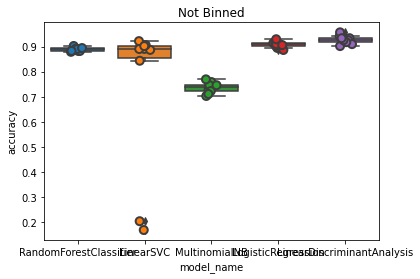

<Figure size 432x288 with 0 Axes>

In [522]:
compare_models(X, y, 'Not Binned')

In [523]:
estimator_sizes = [10, 50, 100, 200]
unbinned_estimator_results = sample_estimator_sizes(estimator_sizes, X, y, is_binned=False)

In [524]:
feature_categories = [letter_cols, person_cols, subscription_cols, famous_cols, bio_cols, geographic_cols, days, year_cols]

In [525]:
unbinned_feature_results, unbinned_models = compare_feature_results(members_final, updated_members_data, feature_categories, is_binned=False)

In [544]:
for bin_model in binned_models:
    
    if 'year_bin' in bin_model['features'][0]:

        rf_model = bin_model['model']
        estimator = rf_model.estimators_[0]
        clf = estimator
        feature_names = bin_model['features']
        target_names = ['0', '1']
        X = bin_model['X']
        y = bin_model['y']
        

        # viz = dtreeviz(clf, X, y,
        #             target_name="target",
        #             feature_names=feature_names,
        #             class_names=list(target_names))
        # viz.save(f'./visualizations/unbinned_decision_tree_features_{feature_names[0]}_estimator0.svg')
        dot_data = StringIO()
        tree.export_graphviz(estimator, out_file=dot_data,  
                        filled=True, rounded=True,
                        special_characters=True,feature_names = feature_names,class_names=target_names)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
        graph.write_png(f'./visualizations/unbinned_decision_tree_features_{feature_names[0]}_estimator0.png')

In [545]:
estimator_results = pd.concat([binned_estimator_results, unbinned_estimator_results])

melted_stats = pd.melt(estimator_results, id_vars=['estimator', 'binned'], value_vars=['kfold_accuracy', 'precision', 'recall', 'accuracy'])

alt.Chart(melted_stats).mark_tick(thickness=3).encode(
    y='variable',
    x='value',
    color='estimator:N',
    row='binned',
)

alt.Chart(...)

In [546]:
feature_results = pd.concat([binned_feature_results, unbinned_feature_results])
feature_results['feature_grouping'] = ''
feature_results['str_features'] = feature_results.features.str.join(',')
feature_results.loc[feature_results['str_features'].str.contains('first_letter'), 'feature_grouping'] = 'First Letter of First or Last Names'
feature_results.loc[feature_results['str_features'].str.contains('gender'), 'feature_grouping'] = 'Person (Title or Gender) or Organization Metadata'
feature_results.loc[feature_results['str_features'].str.contains('volumes'), 'feature_grouping'] = 'Rate of Subscription Volume'
feature_results.loc[feature_results['str_features'].str.contains('viaf'), 'feature_grouping'] = 'Identifiers (VIAF, Wikipedia, etc.)'
feature_results.loc[feature_results['str_features'].str.contains('birth'), 'feature_grouping'] = 'Birth Year or Death Year'
feature_results.loc[feature_results['str_features'].str.contains('addresses'), 'feature_grouping'] = 'Geographic Data'
feature_results.loc[feature_results['str_features'].str.contains('duration'), 'feature_grouping'] = 'Length of Subscription'
feature_results.loc[feature_results['str_features'].str.contains('days'), 'feature_grouping'] = 'Length of Subscription'
feature_results.loc[feature_results['str_features'].str.contains('null_year'), 'feature_grouping'] = 'Membership Years'


In [547]:

melted_stats = pd.melt(feature_results, id_vars=['str_features', 'binned', 'features', 'feature_grouping'], value_vars=['kfold_accuracy', 'precision', 'recall', 'accuracy'])

alt.Chart(melted_stats).mark_tick(thickness=3).encode(
    y=alt.Y('feature_grouping:N', sort='-x'),
    x='value',
    color='variable:N',
    row='binned',
)

alt.Chart(...)

In [529]:
bin_membership_years = True
bin_subscription_lengths = True
bin_members_final, bin_updated_members_data, bin_days, bin_year_cols, bin_volumes = build_feature_data(members_data, events_df, bin_membership_years, bin_subscription_lengths)

In [530]:
bin_subscription_cols = bin_volumes + ['subscription_count']
final_cols = letter_cols + person_cols+ bin_subscription_cols+ famous_cols + bio_cols + bin_days + bin_year_cols + geographic_cols
X = bin_members_final[final_cols]
y = bin_updated_members_data['is_borrower']

In [531]:
feature_categories = [letter_cols+ person_cols+ bin_subscription_cols+ famous_cols+ bio_cols+ geographic_cols+ bin_days+ bin_year_cols]

In [532]:
final_feature_results, final_models = compare_feature_results(bin_members_final, bin_updated_members_data,feature_categories, is_binned=True)

In [533]:
exploded_final_feature_results = final_feature_results.explode(['features', 'importance'])

In [534]:
total_data = []
for index, row in exploded_final_feature_results.iterrows():
    col = row.features
    if col in bin_updated_members_data.columns:
        rows = bin_updated_members_data[[col]]
        if rows[col].isna().any():
            rows = rows[(rows[col].isna() == False)]
        else:
            rows = rows[(rows[col] != False)]

    elif col in bin_members_final.columns:
        rows = bin_members_final[[col]]
        rows = rows[rows[col] > 0]
    total_data.append(len(rows[col]))
        


In [535]:
exploded_final_feature_results['total_data'] = total_data

In [536]:
# feature_results['str_features'] = feature_results.features.str.join(',')
# feature_results.loc[feature_results['str_features'].str.contains('first_letter'), 'feature_grouping'] = 'First Letter of First or Last Names'
# feature_results.loc[feature_results['str_features'].str.contains('gender'), 'feature_grouping'] = 'Person (Title or Gender) or Organization Metadata'
# feature_results.loc[feature_results['str_features'].str.contains('volumes'), 'feature_grouping'] = 'Rate of Subscription Volume'
# feature_results.loc[feature_results['str_features'].str.contains('viaf'), 'feature_grouping'] = 'Identifiers (VIAF, Wikipedia, etc.)'
# feature_results.loc[feature_results['str_features'].str.contains('birth'), 'feature_grouping'] = 'Birth Year or Death Year'
# feature_results.loc[feature_results['str_features'].str.contains('addresses'), 'feature_grouping'] = 'Geographic Data'
# feature_results.loc[feature_results['str_features'].str.contains('duration'), 'feature_grouping'] = 'Length of Subscription'
# feature_results.loc[feature_results['str_features'].str.contains('days'), 'feature_grouping'] = 'Length of Subscription'
# feature_results.loc[feature_results['str_features'].str.contains('null_year'), 'feature_grouping'] = 'Membership Years'

In [537]:
exploded_final_feature_results['color_group'] = None
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(letter_cols), 'color_group'] = 'First Letter of First or Last Names'
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(person_cols), 'color_group'] = 'Person (Title or Gender) or Organization Metadata'
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(bin_subscription_cols), 'color_group'] = 'Rate of Subscription Volume'
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(bio_cols), 'color_group'] = 'Birth Year or Death Year'
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(geographic_cols), 'color_group'] = 'Geographic Data'
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(bin_days), 'color_group'] = 'Length of Subscription'
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(bin_year_cols), 'color_group'] = 'Membership Years'
exploded_final_feature_results.loc[exploded_final_feature_results.features.isin(famous_cols), 'color_group'] = 'Identifiers (VIAF, Wikipedia, etc.)'


In [538]:
exploded_final_feature_results.total_data = exploded_final_feature_results.total_data.astype(float)

In [539]:
exploded_final_feature_results['ratio'] = exploded_final_feature_results['importance'] / exploded_final_feature_results.total_data * 100

In [542]:

selector = alt.selection_multi(fields=['color_group'], bind='legend')
chart = alt.Chart(exploded_final_feature_results).mark_bar().encode(
    y=alt.Y('features:N', sort='-x'),
    x='importance',
    color='color_group:N',
    opacity=alt.condition(selector, alt.value(1), alt.value(0.1)),
).add_selection(selector).properties(
    height=300,
)

In [543]:
base = alt.Chart(exploded_final_feature_results).encode(
    x='importance',
    y='total_data',
).properties(
    height=300,
    width=1000,
)

# selector = alt.selection_single(empty='all', fields=['features'])
selector = alt.selection_multi(fields=['color_group'], bind='legend')

chart1 = alt.layer(
    base.mark_circle().encode(
        color=alt.Color('color_group:N', scale=alt.Scale(scheme='plasma'), sort=alt.EncodingSortField('ratio', op='count', order='descending'), legend=alt.Legend(title='Type of Metadata')),
        tooltip=['features'],
        opacity=alt.condition(selector, alt.value(1), alt.value(0.1)),
    ),
    base.transform_regression('importance', 'total_data').mark_line(color='black', opacity=0.5),
    base.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='features:N',
        color=alt.Color('color_group:N', scale=alt.Scale(scheme='plasma')),
        opacity=alt.condition(selector, alt.value(1), alt.value(0.1)),
    )
).add_selection(selector)

alt.hconcat(chart, chart1)

alt.HConcatChart(...)

In [410]:
# def print_tree_structure(clf):
#     n_nodes = clf.tree_.node_count
#     children_left = clf.tree_.children_left
#     children_right = clf.tree_.children_right
#     feature = clf.tree_.feature
#     threshold = clf.tree_.threshold

#     node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
#     is_leaves = np.zeros(shape=n_nodes, dtype=bool)
#     stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
#     while len(stack) > 0:
#         # `pop` ensures each node is only visited once
#         node_id, depth = stack.pop()
#         node_depth[node_id] = depth

#         # If the left and right child of a node is not the same we have a split
#         # node
#         is_split_node = children_left[node_id] != children_right[node_id]
#         # If a split node, append left and right children and depth to `stack`
#         # so we can loop through them
#         if is_split_node:
#             stack.append((children_left[node_id], depth + 1))
#             stack.append((children_right[node_id], depth + 1))
#         else:
#             is_leaves[node_id] = True

#     print(
#         "The binary tree structure has {n} nodes and has "
#         "the following tree structure:\n".format(n=n_nodes)
#     )
#     for i in range(n_nodes):
#         if is_leaves[i]:
#             print(
#                 "{space}node={node} is a leaf node.".format(
#                     space=node_depth[i] * "\t", node=i
#                 )
#             )
#         else:
#             print(
#                 "{space}node={node} is a split node: "
#                 "go to node {left} if X[:, {feature}] <= {threshold} "
#                 "else to node {right}.".format(
#                     space=node_depth[i] * "\t",
#                     node=i,
#                     left=children_left[i],
#                     feature=feature[i],
#                     threshold=threshold[i],
#                     right=children_right[i],
#                 )
#             )

In [200]:
# y_pred = rf_model.predict(x_val)
# print('Validation Results')
# print(rf_model.score(x_val, y_val))
# print(metrics.recall_score(y_val, y_pred, average=None ))
# print("Precision:",metrics.precision_score(y_val, y_pred, average=None ))
# print('\nTest Results')
# print(rf_model.score(test_features, test_target))
# print(metrics.recall_score(test_target, rf_model.predict(test_features), average=None ))
# print("Precision:",metrics.precision_score(test_target, rf_model.predict(test_features), average=None))

In [201]:
# kfold = KFold(n_splits=10)
# scoring = 'accuracy'
# results = cross_val_score(rf_model, x_train_res, y_train_res,scoring='accuracy', cv=kfold)
# print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

# # print(metrics.classification_report(y_val, y_pred, target_names=members_data['borrowing_records'].unique()))


In [202]:
# from sklearn.metrics import confusion_matrix
# cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
# cnf_matrix
# class_names=[0,1] # name  of classes
# fig, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)
# # create heatmap
# sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')

In [203]:
# print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
# print("Precision:",metrics.precision_score(y_val, y_pred))
# print("Recall:",metrics.recall_score(y_val, y_pred))

In [65]:
# y_pred_proba = rf_model.predict_proba(x_val)
# fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
# auc = metrics.roc_auc_score(y_val, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

In [414]:
rf_model = final_models[0]['model']
X = final_models[0]['X']
y = final_models[0]['y']

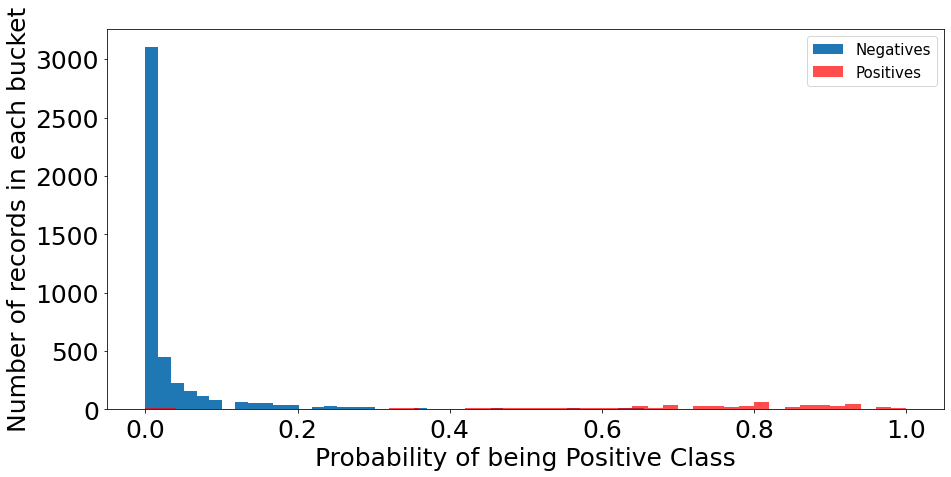

In [425]:
prediction=rf_model.predict_proba(X)[:,1]
plt.figure(figsize=(15,7))
plt.hist(prediction[y==0], bins=50, label='Negatives')
plt.hist(prediction[y==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

In [415]:
predictions_proba = rf_model.predict_proba(X)

In [416]:
predictions_zero = [x[0] for x in predictions_proba]
predictions_one = [x[1] for x in predictions_proba]

In [417]:
final_data = bin_updated_members_data.copy()

In [418]:
final_data['prediction_proba_0'] = predictions_zero
final_data['prediction_proba_1'] = predictions_one
final_data['prediction'] = rf_model.predict(X)

In [421]:
final_data[final_data.is_borrower==0].sort_values(by='prediction_proba_1', ascending=False).head(10)

uri                   name               sort_name  \
410        bishop-elizabeth       Elizabeth Bishop       Bishop, Elizabeth   
4399             simon-mlle             Mlle Simon             Simon, Mlle   
585               briffault       Robert Briffault       Briffault, Robert   
1377           devlin-denis           Denis Devlin           Devlin, Denis   
4198       ruellan-severine       Séverine Ruellan       Ruellan, Séverine   
4747        tintner-adeline        Adeline Tintner        Tintner, Adeline   
290       bazaine-jean-rene      Jean René Bazaine      Bazaine, Jean René   
4132  roger-cornaz-frederic  Frédéric Roger-Cornaz  Roger-Cornaz, Frédéric   
891      chiaromonte-nicola     Nicola Chiaromonte     Chiaromonte, Nicole   
1523         dyett-edmund-g        Edmund G. Dyett        Dyett, Edmund G.   

     title  gender  is_organization  has_card  birth_year  death_year  \
410    NaN  Female            False     False      1911.0      1979.0   
4399  Mlle  Female            False     False         NaN         NaN   
585    NaN    Male            False     False      1876.0      1948.0   
1377   NaN    Male            False     False      1908.0      1959.0   
4198  Mlle  Female            False     False         NaN         NaN   
4747  Miss  Female            False     False      1912.0      2003.0   
290    NaN    Male            False     False      1904.0      2001.0   
4132    M.    Male            False     False      1883.0      1970.0   
891    NaN    Male            False     False      1905.0      1972.0   
1523   NaN    Male            False     False      1902.0      1991.0   

         membership_years                         viaf_url  \
410        1936;1937;1935   http://viaf.org/viaf/71405503/   
4399                 1936                              NaN   
585                  1933    http://viaf.org/viaf/4973560/   
1377                 1932   http://viaf.org/viaf/64049202/   
4198                 1937                              NaN   
4747            1936;1937  http://viaf.org/viaf/109257200/   
290                  1934  http://viaf.org/viaf/109483724/   
4132  1921;1922;1923;1924   http://viaf.org/viaf/41845825/   
891             1936;1937  http://viaf.org/viaf/264608918/   
1523                 1932  http://viaf.org/viaf/279836491/   

                                          wikipedia_url  \
410      https://en.wikipedia.org/wiki/Elizabeth_Bishop   
4399                                                NaN   
585      https://en.wikipedia.org/wiki/Robert_Briffault   
1377         https://en.wikipedia.org/wiki/Denis_Devlin   
4198                                                NaN   
4747                                                NaN   
290   https://en.wikipedia.org/wiki/Jean_Ren%C3%A9_B...   
4132                                                NaN   
891    https://en.wikipedia.org/wiki/Nicola_Chiaromonte   
1523                                                NaN   

              nationalities  \
410           United States   
4399                    NaN   
585   France;United Kingdom   
1377                Ireland   
4198                    NaN   
4747          United States   
290                  France   
4132            Switzerland   
891                   Italy   
1523          United States   

                                              addresses postal_codes  \
410   58 rue de Vaugirard, Paris;Foyer international...  75006;75005   
4399                       29 rue du Canton, Remiremont        88200   
585                              49 rue de Seine, Paris        75006   
1377                           52 rue Gay-Lussac, Paris        75005   
4198                         15 rue Magenta, Versailles        78000   
4747                                15 rue Jacob, Paris        75006   
290                        29 boulevard Berthier, Paris        75017   
4132                                20 rue Jacob, Paris        75006   
891                            8 villa

In [423]:
final_data[final_data.is_borrower==1].sort_values(by='prediction_proba_0', ascending=False).head(10)

uri                      name                  sort_name  \
2680           king-f                   F. King                   King, F.   
294      beach-family    Beach Family / Beaches               Beach Family   
1824  garano-gonzalez  Mariella Garano Gonzalez  Garano Gonzalez, Mariella   
1997  gosse-emilienne           Emilienne Gosse           Gosse, Emilienne   
4814      ullmann-w-e             W. E. Ullmann             Ullmann, W. E.   
2346         hobhouse               U. Hobhouse               Hobhouse, U.   
4493      sonnabend-2                 Sonnabend                  Sonnabend   
1559        eisenberg              K. Eisenberg              Eisenberg, K.   
1865            genet                Jean Genet                Genet, Jean   
1699       fitzgerald           Miss Fitzgerald           Fitzgerald, Miss   

     title  gender  is_organization  has_card  birth_year  death_year  \
2680  Miss  Female            False      True         NaN         NaN   
294    NaN     NaN            False      True         NaN         NaN   
1824   Mme  Female            False      True         NaN         NaN   
1997  Mlle  Female            False      True         NaN         NaN   
4814   Mr.    Male            False      True         NaN         NaN   
2346  Miss  Female            False      True         NaN         NaN   
4493   NaN     NaN            False      True         NaN         NaN   
1559  Miss  Female            False      True         NaN         NaN   
1865   Mr.    Male            False      True         NaN         NaN   
1699  Miss  Female            False      True         NaN         NaN   

     membership_years viaf_url wikipedia_url nationalities  \
2680             1926      NaN           NaN           NaN   
294              1930      NaN           NaN           NaN   
1824             1931      NaN           NaN           NaN   
1997        1929;1930      NaN           NaN           NaN   
4814             1927      NaN           NaN           NaN   
2346             1929      NaN           NaN           NaN   
4493             1938      NaN           NaN           NaN   
1559             1931      NaN           NaN           NaN   
1865        1941;1942      NaN           NaN           NaN   
1699             1937      NaN           NaN           NaN   

                                              addresses postal_codes  \
2680  Hotel de Nice, 135 boulevard du Montparnasse, ...        75006   
294                                                 NaN          NaN   
1824                                                NaN          NaN   
1997                             41 rue de Donai, Paris        75009   
4814                                                NaN          NaN   
2346  70 rue Notre Dame des Champs, Paris;95 bouleva...  75006;75014   
4493                                                NaN          NaN   
1559                             26 rue Pasquier, Paris        75008   
1865                                                NaN          NaN   
1699         Hôtel Malherbe, 11 rue de Vaugirard, Paris        75006   

     arrondissements                          coordinates  \
2680               6                    48.84138, 2.33232   
294              NaN                                  NaN   
1824             NaN                                  NaN   
1997               9                    48.88279, 2.33142   
4814             NaN                                  NaN   
2346            6;14  48.84275, 2.33104;48.83424, 2.33448   
4493             NaN                                  NaN   
1559               8                    48.87293, 2.32364   
1865             NaN                                  NaN   
1699               6                    48.84896, 2.33962   

                                                  notes  \
2680  According to the Shakespeare and Company [addr...   
294                                                 NaN   
1824                          

In [424]:
chart = alt.Chart(final_data).mark_bar().encode(
    x='last_letter:O',
    y='count()',
    color='is_borrower:N'
)

chart1 = alt.Chart(final_data).mark_bar().encode(
    x='last_letter:O',
    y='count()',
    color='prediction_proba_1:Q'
)

alt.vconcat(chart, chart1)

alt.VConcatChart(...)